In [1]:
import zipfile
import csv
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import math
from statsmodels.sandbox.regression.gmm import IV2SLS

In [6]:
with zipfile.ZipFile('listings_mar2023_w_hotspots_and_'+str(150)+'_clusters.zip', 'r') as zip_ref:
    with zip_ref.open('listings_mar2023_w_hotspots_and_'+str(150)+'_clusters.csv', 'r') as file:
        df = pd.read_csv(file)        
        df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
    df1=df[df.price<800]

    df2= df1[~df1.beds.isna()&~df1.reviews_per_month.isna()&~df1.review_scores_accuracy.isna()&~df1.review_scores_checkin.isna()
         &~df1.review_scores_communication.isna()&~df1.review_scores_location.isna()&~df1.review_scores_value.isna()]

    df2 = df2.copy() 
    # create market share from reviews
    df2.loc[:,'share'] =df2['reviews_per_month']/(df2.groupby('cluster_num')['reviews_per_month'].transform('sum')*3)

    # 2/3 is arbitrary, won't affect result much, create mean valuation of the listing
    df2['mean_value'] =np.log(df2['share']/(2/3))
        
origianl_price = df2.price.mean()
optimal_price_df_default = demand_est_default(df2)
optimal_price_df = demand_est(df2)

mean_optimal_price_df_default =optimal_price_df_default['new price'].mean()
mean_price_default_new_listing = optimal_price_df_default['new price'][-100:].mean()


In [5]:
def demand_est(df):
    df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
    df1=df[df.price<800]

    df2= df1[~df1.beds.isna()&~df1.reviews_per_month.isna()&~df1.review_scores_accuracy.isna()&~df1.review_scores_checkin.isna()
         &~df1.review_scores_communication.isna()&~df1.review_scores_location.isna()&~df1.review_scores_value.isna()]
    
    df2 = df2.copy() 
    # create market share from reviews
    df2.loc[:,'share'] =df2['reviews_per_month']/(df2.groupby('cluster_num')['reviews_per_month'].transform('sum')*3)

    # 2/3 is arbitrary, won't affect result much, create mean valuation of the listing
    df2['mean_value'] =np.log(df2['share']/(2/3))
    
    df3=df2.copy()

    # instrument for price endogeneity
    df3.loc[:,'IV'] = df3.groupby(['cluster_num'])['id'].transform('count')

    ################################################################################################################
    # get features
    license_dummy=1*(~df3.license.isna()) 
    # Fill NAN by "missing" string
    df3[['host_response_time']] = df3[['host_response_time']].fillna('Missing_response')
    host_response_dummy=pd.get_dummies(df3.host_response_time)
    #room_type dummy
    room_type_dummy=pd.get_dummies(df3.room_type)
    super_host_dummy =1*(df3.host_is_superhost=="t")

    amentity_count=df3.amenities.str.split().str.len()
    wifi = 1*df3.amenities.str.lower().str.contains('wifi', regex=True) 
    washer = 1*df3.amenities.str.lower().str.contains('washer', regex=True) 
    dryer = 1*df3.amenities.str.lower().str.replace("hair dryer", " ").str.lower().str.contains('dryer', regex=True)
    hair_dryer = 1*df3.amenities.str.lower().str.contains('hair dryer', regex=True) 
    free_parking = 1*df3.amenities.str.lower().str.contains('free parking', regex=True) 
    AC = 1*df3.amenities.str.lower().str.contains('air conditioning', regex=True) 
    TV= 1*df3.amenities.str.lower().str.contains('tv', regex=True) 
    hottub = 1*df3.amenities.str.lower().str.contains('hot tub', regex=True) 
    coffee = 1*df3.amenities.str.lower().str.contains('coffee', regex=True) 
    microwave = 1*df3.amenities.str.lower().str.contains('microwave', regex=True) 
    pool = 1*df3.amenities.str.lower().str.contains('pool', regex=True) 
    shampoo = 1*df3.amenities.str.lower().str.contains('shampoo', regex=True) 
    ################################################################################################################
    # run regression
    Y=df3.mean_value
    X=pd.concat([df3.price,df3.beds,license_dummy,
                 room_type_dummy,super_host_dummy,df3.review_scores_rating,amentity_count,wifi,
                 washer,dryer,hair_dryer,free_parking,AC,TV,hottub,coffee,microwave,pool,shampoo],axis=1)
    exog_constant=X
    #sm.add_constant(X)
    endog = Y
    instr_constant = sm.add_constant(pd.concat([df3.IV,df3.beds,license_dummy,
                 room_type_dummy,super_host_dummy,df3.review_scores_rating,amentity_count,wifi,
                 washer,dryer,hair_dryer,free_parking,AC,TV,hottub,coffee,microwave,pool,shampoo],axis=1))
    endog_results = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
    
    markup =[]
    df3 = df3.copy()
    # number of the markets (hotspots)
    M = df3['cluster_num'].nunique()
    Group_market = df3.groupby('cluster_num')

    ################################################################################################################
    # markup
    ela = [] 
    for num, i in enumerate(df3['cluster_num'].unique()):
        submarket = Group_market.get_group(i)
        share_m = np.array(submarket.share)
        dsdp_m =  endog_results.params['price']*(np.diag(share_m)-np.outer(share_m,share_m)) #price derivatives

        #ela
        ela_m =dsdp_m*np.array(np.array(submarket.price).reshape(-1, 1) )/np.array(submarket.share)# that's how i compute elasticities  
        ela.append(ela_m)

        # markup
        host_id = submarket.host_id.to_numpy()
        T = host_id [:, np.newaxis] == host_id 
        markup.append(-np.dot(np.linalg.inv(T*dsdp_m),share_m))
         # assign markup back to dataFrame df3
        df3.loc[df3['cluster_num'] == i, 'markup'] = markup[num]
    
    #marginal cost
    df3['margin_perc'] = df3.markup/df3.price
    df3['mc'] = df3['price']-df3['markup']
    # create 100 new fake listing which is the as the row 101-200
    new_row = df3.iloc[101:200,:]

    df3.reset_index(drop=True, inplace=True)
    new_row.reset_index(drop=True, inplace=True)
    df4 = pd.concat([df3,new_row], axis=0,ignore_index=True)
    
    ################################################################################################################
    # compute optimal pricing from structural model
    tol = 1e-6


    Group_market4 = df4.groupby('cluster_num')
    for num, i in enumerate(df4['cluster_num'].unique()):
        submarket = Group_market4.get_group(i)
        new_price = np.array(submarket.price)
        diff=1
        while diff >tol: 
            mc= np.array(submarket.mc)
            new_share_m = np.array(submarket.mean_value)-endog_results.params['price']*(np.array(submarket.price)-new_price)
            dsdp_m = endog_results.params['price']*(np.diag(new_share_m)-np.outer(new_share_m,new_share_m)) #price derivatives

            #ela
            ela_m =dsdp_m*np.array(np.array(new_price).reshape(-1, 1) )/np.array(new_share_m)# that's how i compute elasticities  
            #ela.append(ela_m)

            # markup
            host_id = submarket.host_id.to_numpy()
            T = host_id [:, np.newaxis] == host_id 
            new_markup_m = -np.dot(np.linalg.inv(T*dsdp_m),new_share_m)
            old_price = new_price

            new_price =  mc+ new_markup_m
            diff= np.max(np.abs(old_price-new_price))
            #markup.append()

        # assign markup back to dataFrame df4
        df4.loc[df4['cluster_num'] == i, 'new markup'] = new_markup_m
        df4.loc[df4['cluster_num'] == i, 'new price'] = new_price

    return df4

In [87]:
no_clusters = np.arange(50,501,50)
mean_price=[]
mean_price_new_lising=[]
for i in no_clusters:
    filename = 'listings_mar2023_w_hotspots_and_' + str(i)+ '_clusters.zip'
    with zipfile.ZipFile('listings_mar2023_w_hotspots_and_'+str(i)+'_clusters.zip', 'r') as zip_ref:
        with zip_ref.open('listings_mar2023_w_hotspots_and_'+str(i)+'_clusters.csv', 'r') as file:
            df = pd.read_csv(file)        
    optimal_price_df = demand_est(df)
    mean_price.append(optimal_price_df['new price'].mean())
    mean_price_new_lising.append(optimal_price_df['new price'][-100:].mean())

(140.0, 186.8715210133205)

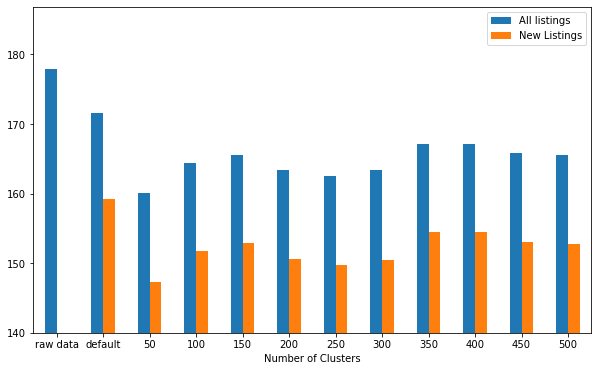

In [97]:
df_plot = pd.DataFrame({'Number of Clusters':['raw data']+['default']+no_clusters.tolist(), 
                        'All listings':[origianl_price]+[mean_optimal_price_df_default]+mean_price,
                        'New Listings':[0]+[mean_price_default_new_listing]+mean_price_new_lising})
ax = df_plot.plot.bar(x='Number of Clusters', y=['All listings','New Listings'], rot=0,figsize=(10,6))
ax.set_ylim(bottom=140)

In [52]:
mean_price

[160.02588446271193, 164.4682540315789]

In [4]:

#no clusters. Using default  neighbourhood
def demand_est_default(df):
    df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
    df1=df[df.price<800]

    df2= df1[~df1.beds.isna()&~df1.reviews_per_month.isna()&~df1.review_scores_accuracy.isna()&~df1.review_scores_checkin.isna()
         &~df1.review_scores_communication.isna()&~df1.review_scores_location.isna()&~df1.review_scores_value.isna()]
    
    df2 = df2.copy() 
    # create market share from reviews
    df2.loc[:,'share'] =df2['reviews_per_month']/(df2.groupby('neighbourhood_cleansed')['reviews_per_month'].transform('sum')*3)

    # 2/3 is arbitrary, won't affect result much, create mean valuation of the listing
    df2['mean_value'] =np.log(df2['share']/(2/3))
    
    df3=df2.copy()

    # instrument for price endogeneity
    df3.loc[:,'IV'] = df3.groupby(['neighbourhood_cleansed'])['id'].transform('count')

    ################################################################################################################
    # get features
    license_dummy=1*(~df3.license.isna()) 
    # Fill NAN by "missing" string
    df3[['host_response_time']] = df3[['host_response_time']].fillna('Missing_response')
    host_response_dummy=pd.get_dummies(df3.host_response_time)
    #room_type dummy
    room_type_dummy=pd.get_dummies(df3.room_type)
    super_host_dummy =1*(df3.host_is_superhost=="t")

    amentity_count=df3.amenities.str.split().str.len()
    wifi = 1*df3.amenities.str.lower().str.contains('wifi', regex=True) 
    washer = 1*df3.amenities.str.lower().str.contains('washer', regex=True) 
    dryer = 1*df3.amenities.str.lower().str.replace("hair dryer", " ").str.lower().str.contains('dryer', regex=True)
    hair_dryer = 1*df3.amenities.str.lower().str.contains('hair dryer', regex=True) 
    free_parking = 1*df3.amenities.str.lower().str.contains('free parking', regex=True) 
    AC = 1*df3.amenities.str.lower().str.contains('air conditioning', regex=True) 
    TV= 1*df3.amenities.str.lower().str.contains('tv', regex=True) 
    hottub = 1*df3.amenities.str.lower().str.contains('hot tub', regex=True) 
    coffee = 1*df3.amenities.str.lower().str.contains('coffee', regex=True) 
    microwave = 1*df3.amenities.str.lower().str.contains('microwave', regex=True) 
    pool = 1*df3.amenities.str.lower().str.contains('pool', regex=True) 
    shampoo = 1*df3.amenities.str.lower().str.contains('shampoo', regex=True) 
    ################################################################################################################
    # run regression
    Y=df3.mean_value
    X=pd.concat([df3.price,df3.beds,license_dummy,
                 room_type_dummy,super_host_dummy,df3.review_scores_rating,amentity_count,wifi,
                 washer,dryer,hair_dryer,free_parking,AC,TV,hottub,coffee,microwave,pool,shampoo],axis=1)
    exog_constant=X
    #sm.add_constant(X)
    endog = Y
    instr_constant = sm.add_constant(pd.concat([df3.IV,df3.beds,license_dummy,
                 room_type_dummy,super_host_dummy,df3.review_scores_rating,amentity_count,wifi,
                 washer,dryer,hair_dryer,free_parking,AC,TV,hottub,coffee,microwave,pool,shampoo],axis=1))
    endog_results = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
    
    markup =[]
    df3 = df3.copy()
    # number of the markets (hotspots)
    M = df3['neighbourhood_cleansed'].nunique()
    Group_market = df3.groupby('neighbourhood_cleansed')

    ################################################################################################################
    # markup
    ela = [] 
    for num, i in enumerate(df3['neighbourhood_cleansed'].unique()):
        submarket = Group_market.get_group(i)
        share_m = np.array(submarket.share)
        dsdp_m =  endog_results.params['price']*(np.diag(share_m)-np.outer(share_m,share_m)) #price derivatives

        #ela
        ela_m =dsdp_m*np.array(np.array(submarket.price).reshape(-1, 1) )/np.array(submarket.share)# that's how i compute elasticities  
        ela.append(ela_m)

        # markup
        host_id = submarket.host_id.to_numpy()
        T = host_id [:, np.newaxis] == host_id 
        markup.append(-np.dot(np.linalg.inv(T*dsdp_m),share_m))
         # assign markup back to dataFrame df3
        df3.loc[df3['neighbourhood_cleansed'] == i, 'markup'] = markup[num]
    
    #marginal cost
    df3['margin_perc'] = df3.markup/df3.price
    df3['mc'] = df3['price']-df3['markup']
    # create 100 new fake listing which is the as the row 101-200
    new_row = df3.iloc[101:200,:]

    df3.reset_index(drop=True, inplace=True)
    new_row.reset_index(drop=True, inplace=True)
    df4 = pd.concat([df3,new_row], axis=0,ignore_index=True)
    
    ################################################################################################################
    # compute optimal pricing from structural model
    tol = 1e-6


    Group_market4 = df4.groupby('neighbourhood_cleansed')
    for num, i in enumerate(df4['neighbourhood_cleansed'].unique()):
        submarket = Group_market4.get_group(i)
        new_price = np.array(submarket.price)
        diff=1
        while diff >tol: 
            mc= np.array(submarket.mc)
            new_share_m = np.array(submarket.mean_value)-endog_results.params['price']*(np.array(submarket.price)-new_price)
            dsdp_m = endog_results.params['price']*(np.diag(new_share_m)-np.outer(new_share_m,new_share_m)) #price derivatives

            #ela
            ela_m =dsdp_m*np.array(np.array(new_price).reshape(-1, 1) )/np.array(new_share_m)# that's how i compute elasticities  
            #ela.append(ela_m)

            # markup
            host_id = submarket.host_id.to_numpy()
            T = host_id [:, np.newaxis] == host_id 
            new_markup_m = -np.dot(np.linalg.inv(T*dsdp_m),new_share_m)
            old_price = new_price

            new_price =  mc+ new_markup_m
            diff= np.max(np.abs(old_price-new_price))
            #markup.append()

        # assign markup back to dataFrame df4
        df4.loc[df4['neighbourhood_cleansed'] == i, 'new markup'] = new_markup_m
        df4.loc[df4['neighbourhood_cleansed'] == i, 'new price'] = new_price

    return df4

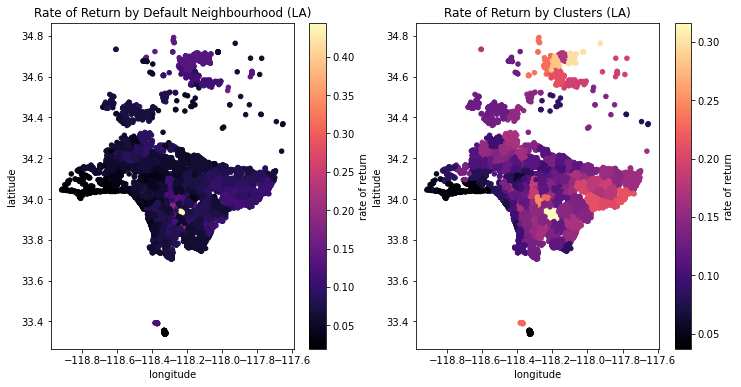

In [16]:
# plot using 150 clusters
#Getting unique labels
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
df_plot = optimal_price_df_default
df_plot2 = optimal_price_df
df_plot['rate of return'] = df_plot['margin_perc'].groupby(df_plot['neighbourhood_cleansed']).transform('mean')
df_plot2['rate of return'] = df_plot2['margin_perc'].groupby(df_plot2['cluster_num']).transform('mean')

axes[0].title.set_text('Rate of Return by Default Neighbourhood (LA)')
axes[1].title.set_text('Rate of Return by Clusters (LA)')
df_plot.plot.scatter('longitude','latitude',  c='rate of return', colormap='magma', figsize=(10,10),ax = axes[0],subplots=True)
df_plot2.plot.scatter('longitude','latitude',  c='rate of return', colormap='magma', figsize=(10,10),ax = axes[1],subplots=True)

plt.show()


In [ ]:
optimal_price_df